In [1]:
import time
start_time=time.time()

In [2]:
#from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import interpolate
import numpy as np
import pandas as pd
import json
import itertools

from astropy.io import fits
import astropy.units as u
#from astropy.table import Table

import turbustat.statistics as tss

import statsmodels.api as sm
#from scipy.fftpack import fft
#import math
#import sys
#import os
#from PIL import Image

from sabreMod import sosf
import strucfunc

Text(0.5, 1.0, 'H$_{α}$ Flux')

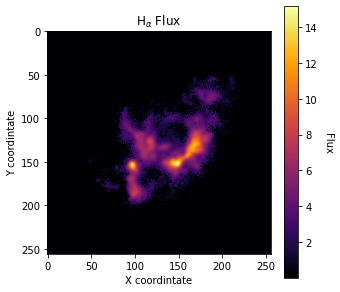

In [3]:
FitsFile= 'Obs/TAURUS.604.Ha.Flux'
hdul=fits.open(FitsFile + '.fits')
fig, ax = plt.subplots(figsize=(5, 5))
image_data=hdul[0].data
plt.imshow(image_data, cmap='inferno')
ax.set_xlabel('X coordintate')
ax.set_ylabel('Y coordintate')
cbar = plt.colorbar()
cbar.set_label('Flux', rotation=270, labelpad=15)  
plt.title('H$_{α}$ Flux')

In [4]:
flx=hdul[0].data
df=pd.DataFrame(flx)
dffx=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'I'})
dffx.describe()

,X,Y,I
count,65536.000000,65536.000000,6.553600e+04
mean,127.500000,127.500000,5.889378e-01
std,73.900834,73.900834,1.665959e+00
min,0.000000,0.000000,3.787646e-09
25%,63.750000,63.750000,3.787646e-09
50%,127.500000,127.500000,3.787646e-09
75%,191.250000,191.250000,3.787646e-09
max,255.000000,255.000000,1.515018e+01


Text(0.5, 1.0, 'H$_{α}$ Radial Velocity')

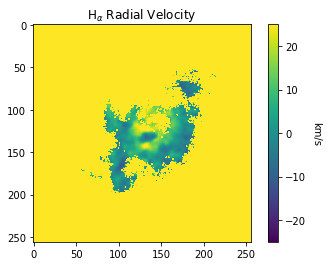

In [5]:
FitsFile= 'Obs/TAURUS.604.Ha.RV'
hdul=fits.open(FitsFile + '.fits')
image_data=hdul[0].data
plt.imshow(image_data, cmap='viridis')
ax.set_xlabel('X coordintate')
ax.set_ylabel('Y coordintate')
cbar = plt.colorbar()
cbar.set_label('km/s', rotation=270, labelpad=15)  
plt.clim(-25,25) 
plt.title('H$_{α}$ Radial Velocity')

In [6]:
vel=hdul[0].data
df=pd.DataFrame(vel)
dfvr=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'RV'})
dfvr.describe()

,X,Y,RV
count,65536.000000,65536.000000,65536.000000
mean,127.500000,127.500000,335.500406
std,73.900834,73.900834,139.319611
min,0.000000,0.000000,-16.693176
25%,63.750000,63.750000,393.980011
50%,127.500000,127.500000,393.980011
75%,191.250000,191.250000,393.980011
max,255.000000,255.000000,393.980011


Text(0.5, 1.0, 'H$_{α}$ σ$_{disp}$')

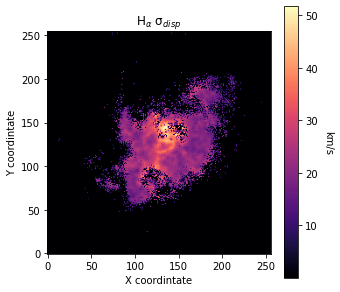

In [7]:
FitsFile= 'Obs/TAURUS.604.Ha.Sigma'
hdul=fits.open(FitsFile + '.fits')
fig, ax = plt.subplots(figsize=(5, 5))
image_data=hdul[0].data
plt.imshow(image_data, cmap='magma')
ax.set_xlabel('X coordintate')
ax.set_ylabel('Y coordintate')
cbar = plt.colorbar()
cbar.set_label('km/s', rotation=270, labelpad=15)  
plt.gca().invert_yaxis()
plt.title('H$_{α}$ σ$_{disp}$')

In [8]:
sig=hdul[0].data
df=pd.DataFrame(sig)
df=df.reindex(index=df.index[::-1])
dsig=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'Sig'})
dsig.describe()

,X,Y,Sig
count,65536.000000,65536.000000,6.553600e+04
mean,127.500000,127.500000,3.607881e+00
std,73.900834,73.900834,8.906863e+00
min,0.000000,0.000000,1.291134e-08
25%,63.750000,63.750000,1.291134e-08
50%,127.500000,127.500000,1.291134e-08
75%,191.250000,191.250000,1.291134e-08
max,255.000000,255.000000,5.164933e+01


In [9]:
data=dfvr
data['I']=dffx.I
data['Sig']=dsig.Sig
data.describe()

,X,Y,RV,I,Sig
count,65536.000000,65536.000000,65536.000000,6.553600e+04,6.553600e+04
mean,127.500000,127.500000,335.500406,5.889378e-01,3.607881e+00
std,73.900834,73.900834,139.319611,1.665959e+00,8.906863e+00
min,0.000000,0.000000,-16.693176,3.787646e-09,1.291134e-08
25%,63.750000,63.750000,393.980011,3.787646e-09,1.291134e-08
50%,127.500000,127.500000,393.980011,3.787646e-09,1.291134e-08
75%,191.250000,191.250000,393.980011,3.787646e-09,1.291134e-08
max,255.000000,255.000000,393.980011,1.515018e+01,5.164933e+01


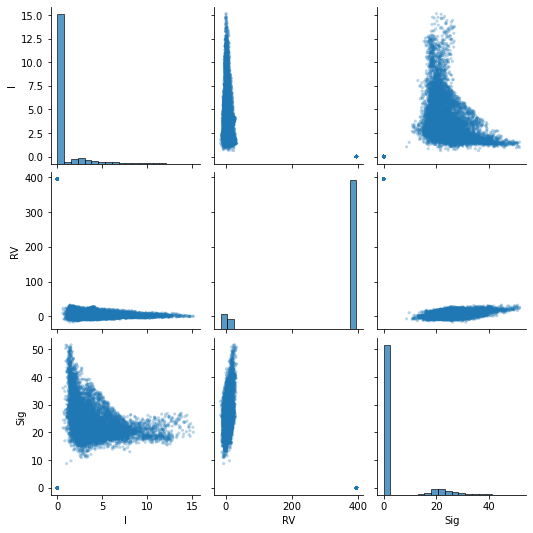

In [10]:
sns.pairplot(data, 
             vars=["I","RV","Sig"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

In [11]:
mI=(data.I>data.I.mean()+0.5*data.I.std())&(data.Sig>data.Sig.mean()+0.5*data.Sig.std())
data=data[mI]

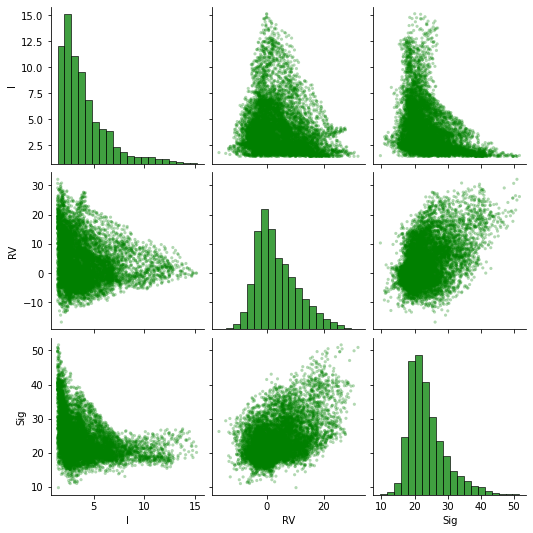

In [12]:
sns.pairplot(data, 
             vars=["I","RV","Sig"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none',color='green'),
             diag_kws=dict(bins=20, color="green"),
            )

In [13]:
data.describe()

,X,Y,RV,I,Sig
count,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000
mean,130.015247,138.798633,3.564254,4.017141,23.751665
std,33.245833,35.100884,7.391004,2.307828,5.653767
min,50.000000,45.000000,-16.693176,1.422287,9.705013
25%,106.000000,109.000000,-1.850128,2.393386,19.786402
50%,131.000000,139.000000,1.922028,3.357099,22.443563
75%,155.000000,169.000000,8.060150,4.908373,26.360056
max,206.000000,222.000000,32.009949,15.150179,51.649326


In [14]:
data.sem()

X      0.340916
Y      0.359938
RV     0.075790
I      0.023665
Sig    0.057976
dtype: float64

Text(0.5, 1.0, 'H$_{α}$ Flux')

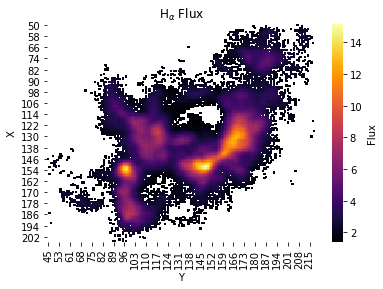

In [15]:
datal=data.copy()
#datal.I=np.log10(datal.I)
datal.X=datal.X.astype(int)
dataH_f=(datal.round(2)).pivot(index='X', columns='Y', values='I')
sns.heatmap(dataH_f, cmap="inferno",xticklabels='auto',cbar_kws={'label': 'Flux'})
plt.title('H$_{α}$ Flux')

Text(0.32, 0.9, '60 pc')

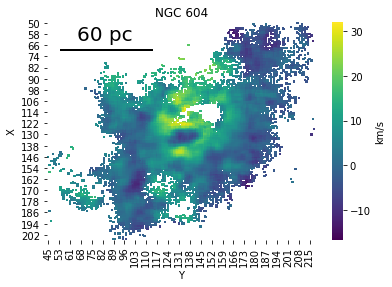

In [16]:

fig = plt.figure()
ax = fig.add_subplot()

datal=data.copy()

dataH_rv=(datal.round(2)).pivot(index='X', columns='Y', values='RV')
sns.heatmap(dataH_rv, cmap="viridis",cbar_kws={'label': 'km/s'})
plt.title('NGC 604')

plt.axhline(y=20, xmin=0.05, xmax=0.39, linewidth=2, color = 'k')

ax.text(0.32, 0.9, '60 pc',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=20)


Text(0.5, 1.0, 'H$_{α}$ σ')

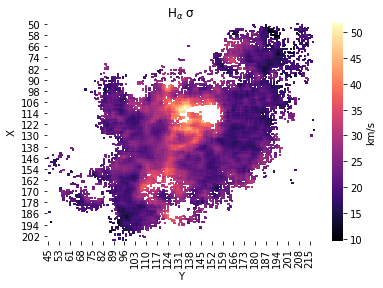

In [17]:
datal=data.copy()
dataH_s=(datal.round(2)).pivot(index='X', columns='Y', values='Sig')
sns.heatmap(dataH_s, cmap="magma",cbar_kws={'label': 'km/s'})
plt.title('H$_{α}$ σ')
#plt.savefig('TAURUS/Imgs/A/'+reg+'SH.png')

In [18]:
data['SigDisp']=(data.Sig**2-9.08**2-14.5**2)**0.5

<ipython-input-18-f66476a56c25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SigDisp']=(data.Sig**2-9.08**2-14.5**2)**0.5


In [19]:
data.describe()

,X,Y,RV,I,Sig,SigDisp
count,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9021.000000
mean,130.015247,138.798633,3.564254,4.017141,23.751665,16.210536
std,33.245833,35.100884,7.391004,2.307828,5.653767,7.698124
min,50.000000,45.000000,-16.693176,1.422287,9.705013,0.223411
25%,106.000000,109.000000,-1.850128,2.393386,19.786402,10.688729
50%,131.000000,139.000000,1.922028,3.357099,22.443563,15.026313
75%,155.000000,169.000000,8.060150,4.908373,26.360056,20.471407
max,206.000000,222.000000,32.009949,15.150179,51.649326,48.733526


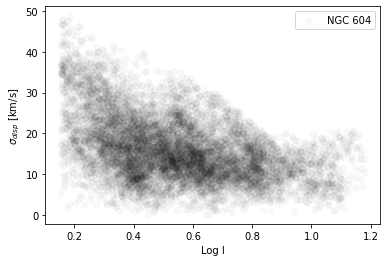

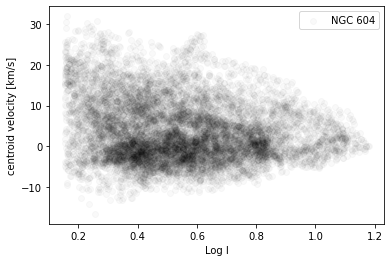

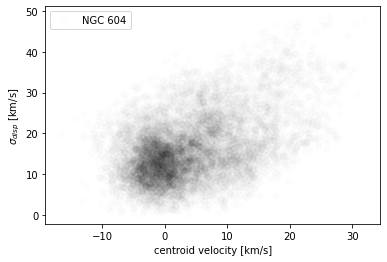

In [20]:
fig, ax = plt.subplots()
plt.scatter(np.log10(data.I),data.SigDisp, alpha=0.025, color='k',label='NGC 604')

ax.set_xlabel('Log I')
ax.set_ylabel('$σ_{disp}$ [km/s]')
plt.legend()

fig, ax = plt.subplots()
plt.scatter(np.log10(data.I),data.RV, alpha=0.025, color='k',label='NGC 604')

ax.set_xlabel('Log I')
ax.set_ylabel('centroid velocity [km/s]')
plt.legend()

fig, ax = plt.subplots()
plt.scatter(data.RV,data.SigDisp, alpha=0.008, color='k',label='NGC 604')

ax.set_xlabel('centroid velocity [km/s]')
ax.set_ylabel('$σ_{disp}$ [km/s]')
plt.legend()



In [21]:
bins=25

In [22]:
(data.RV.max()-data.RV.min())/bins

1.9481250019240668

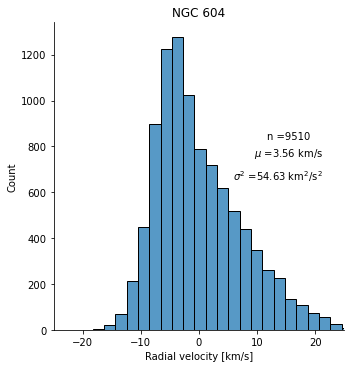

In [23]:
#fig, ax = plt.subplots()

sns.displot(data.RV-data.RV.mean(),bins=25)
plt.xlim(-25,25)

plt.text(0.70, 0.90,'n ='+str(data.RV.count()), ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.70, 0.82,'$μ$ ='+str(np.round(data.RV.mean(),2))+' km/s', ha='center', va='center', transform=ax.transAxes, color='k')
plt.text(0.67, 0.72,'$σ^{2}$ ='+str(np.round(data.RV.var(),2))+' km$^{2}$/s$^{2}$', ha='center', va='center', transform=ax.transAxes, color='k')

plt.title('NGC 604')

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

plt.xlabel('Radial velocity [km/s]')
plt.savefig('Hist//604.pdf', bbox_inches='tight')

Structure Function

In [31]:
sb=np.array(dataH_f)

In [32]:
vv=np.array(dataH_rv)

In [33]:
ss=np.array(dataH_s)

In [34]:
# Replace spurious values in the arrays
m = ~np.isfinite(sb*vv*ss) | (sb < 0.0)
sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

<ipython-input-34-d66c5605846e>:2: RuntimeWarning: invalid value encountered in less
  m = ~np.isfinite(sb*vv*ss) | (sb < 0.0)


In [35]:
rslt = strucfunc.strucfunc_numba_parallel(vv, wmap=sb, dlogr=0.15)

In [36]:
good = (~m) & (sb > 0.001)
rslt["Unweighted mean velocity"] = np.mean(vv[good])
rslt["Unweighted sigma^2"] = np.var(vv[good])
v0w = rslt["Weighted mean velocity"] = np.average(vv, weights=sb)
rslt["Weighted sigma^2"] = np.average((vv - v0w)**2, weights=sb)

In [37]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [70]:
jsonfilename = "SFdata//604.json"
with open(jsonfilename, "w") as f:
    json.dump(rslt, fp=f, indent=3, cls=MyEncoder)
print(jsonfilename, end="")

SFdata//604sfh.json

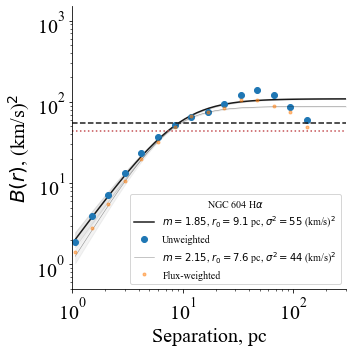

In [39]:
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def bfunc(r, r0, sig2, m):
    "Theoretical structure function"
    C = 1.0 / (1.0 + (r/r0)**m)
    return 2.0*sig2*(1 - C)

data = json.load(open("604sfh.json"))

sns.set_color_codes()
fig, ax = plt.subplots(figsize=(5, 5))

figfile = "604.pdf"

pixscale = 0.26 # arcsec
pixscale *= 4.09              # parsec
r = pixscale * 10**np.array(data["log10 r"])
B = np.array(data["Unweighted B(r)"])
sig2 = data["Unweighted sigma^2"]
B_w = np.array(data["Weighted B(r)"])
sig2_w = data["Weighted sigma^2"]

# Plot fit to unweighted strucfunc
rgrid = pixscale * np.logspace(0.0, 2.7)
r0 = np.interp(sig2, B, r)
m = 1.85
flabel = rf"$m = {m:.2f}$, $r_0 = {r0:.1f}$ pc, $\sigma^2 = {sig2:.0f}$ (km/s)$^2$"
ax.fill_between(
    rgrid,
    bfunc(rgrid, r0, sig2, m - 0.1),
    bfunc(rgrid, r0, sig2, m + 0.1),
    color="k", alpha=0.1,
)
ax.plot(rgrid, bfunc(rgrid, r0, sig2, m), color="k", label=flabel)

# Plot points from unweighted strucfunc
ax.plot(r, B, 'o', label="Unweighted")


# Plot fit to weighted strucfunc
r0_w = np.interp(sig2_w, B_w, r)
m_w = 2.15
flabel_w = rf"$m = {m_w:.2f}$, $r_0 = {r0_w:.1f}$ pc, $\sigma^2 = {sig2_w:.0f}$ (km/s)$^2$"
ax.fill_between(
    rgrid,
    bfunc(rgrid, r0_w, sig2_w, m_w - 0.1),
    bfunc(rgrid, r0_w, sig2_w, m_w + 0.1),
    color="k", alpha=0.05,
)
ax.plot(rgrid, bfunc(rgrid, r0_w, sig2_w, m_w), lw=0.5, color="k", alpha=0.5, label=flabel_w)

# Plot points from weighted strucfunc
ax.plot(r, B_w, 'o', ms=3, alpha=0.5, label="Flux-weighted")


#melnick_r = np.array([2.5, 7.5, 12.5, 17.5, 22.5, 27.5])
#melnick_B = np.array([2.0, 2.1, 2.2, 2.2, 2.25, 2.25]) * 18.2**2
#ax.plot(melnick_r, melnick_B, 's', label="Melnick+ (2020)", color="y", zorder=-10)

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="10"

ax.axhline(sig2, color="k", ls="--")
ax.axhline(sig2_w, color="r", ls=":")
ax.legend(title=r"NGC 604 H$\alpha$")
ax.set(
    xscale = "log",
    yscale = "log",
    ylim  = [0.5, 1500],
    xlim  = [1, 300],
    xlabel = "Separation, pc",
    ylabel = r"$B(r)$, (km/s)$^2$",
)
fig.tight_layout()
sns.despine()
#fig.savefig(figfile)
#fig.savefig(figfile.replace(".pdf", ".jpg"))

Delta Variance

In [40]:
hdul = fits.open('Obs/604RV.fits')
vmed = np.nanmedian(hdul[0].data)
m = np.isfinite(hdul[0].data)
hdul[0].data[~m] = vmed

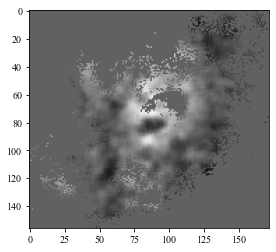

In [41]:
plt.imshow(hdul[0].data, cmap='gray')

In [42]:
dvar = tss.DeltaVariance(hdul[0])

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.924
Model:                            WLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     92.25
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           2.87e-07
Time:                        11:28:20   Log-Likelihood:                 20.294
No. Observations:                  15   AIC:                            -36.59
Df Residuals:                      13   BIC:                            -35.17
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7535      0.048    -15.552      0.0

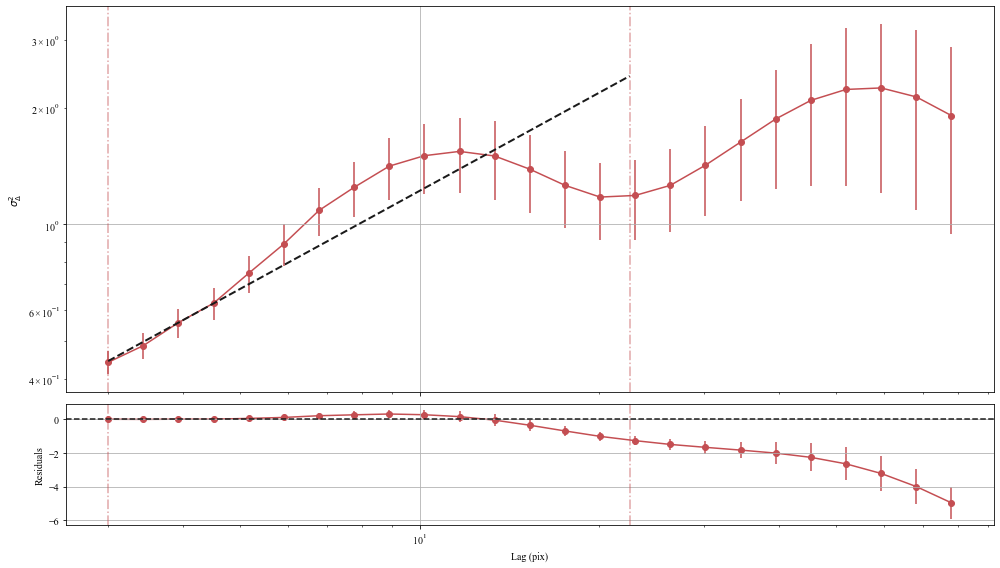

In [43]:
plt.figure(figsize=(14, 8))
dvar.run(verbose=True, boundary="fill",xlow=3*u.pix, xhigh=22.5*u.pix,)

In [69]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 562.5762267112732 seconds ---
